# Deep learning in genomics

This notebook is based on the [jupyter notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [fastai](https://www.fast.ai) library based on [PyTorch](https://pytorch.org).

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai import *
from fastai.vision import *

In [2]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [6]:
# fastai version?
__version__

'1.0.31.dev0'

# Data setup

## Data loading

In [7]:
import requests

In [9]:
URL_seq = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

In [21]:
# get data from URL
seq_raw = requests.get(URL_seq).text.split('\n')
seq_raw = list(filter(None, seq)) # Removes empty lists

In [22]:
# check length
len(seq_raw)

2000

In [26]:
# setup df from list
seq_df = pd.DataFrame(seq_raw, columns=['Sequences'])

In [434]:
# show head of dataframe
#seq_df.head()

In [91]:
URL_labels = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

In [97]:
seq_labels = requests.get(URL_labels).text.split('\n')
seq_labels = list(filter(None, seq_labels)) # Removes empty entries

In [102]:
len(seq_labels)

2000

In [103]:
seq_df['Target'] = seq_labels

In [104]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [105]:
seq_labels = np.array(seq_labels) # transform to np.array

## Data encoding test (incorporated into "open_seq_image" function)

In [86]:
# setup class instance to encode the four different bases to integer values (1D)
int_enc = LabelEncoder()

In [87]:
# setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
one_hot_enc = OneHotEncoder(categories=[range(4)])

In [88]:
seq_enc = []

for s in seq:
    enc = int_enc.fit_transform(list(s)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    seq_enc.append(enc.toarray()) # export sparse matrix to np array

In [89]:
len(seq_enc)

2000

In [462]:
seq_enc[0].T, seq_enc[0].T.shape

(array([[0., 0., 0., 1., ..., 0., 1., 0., 0.],
        [1., 1., 0., 0., ..., 1., 0., 1., 1.],
        [0., 0., 1., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]), (4, 50))

In [311]:
PIL.Image.fromarray(seq_enc[0].T.astype('uint8')*255).convert('P')

## Data setup for NN

In [347]:
def _maybe_squeeze(arr): return (arr if is1d(arr) else np.squeeze(arr))

In [435]:
# open sequence image function
def open_seq_image(seq:str, div:bool=True, cls:type=Image)->Image:
    "Return `Image` object created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    
    # https://stackoverflow.com/questions/22902040/convert-black-and-white-array-into-an-image-in-python
    x = PIL.Image.fromarray(enc.astype('uint8')*255).convert('P')
        
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
    return cls(x)

In [436]:
# test open sequence image function
open_seq_image('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC')

In [437]:
class SeqItemList(ImageItemList):
    _bunch,_square_show = ImageDataBunch,True
    def __post_init__(self):
        super().__post_init__()
        self.sizes={}
    
    def open(self, seq): return open_seq_image(seq)
    
    def get(self, i):
        seq = self.items[i][0]
        res = self.open(seq)
        return res
    
    @classmethod
    def import_from_df(cls, df:DataFrame, cols:IntsOrStrs=0, **kwargs)->'ItemList':
        "Get the sequences in `col` of `df` and will had `path/folder` in front of them, `suffix` at the end."
        return _maybe_squeeze(cls(items=df[cols].values))

In [438]:
data = (SeqItemList.import_from_df(seq_df, ['Sequences'])
        .split_by_idxs(range(1800), range(1800,2000))
        .label_from_list(seq_df['Target'].values)
        .databunch())

In [439]:
# why is y data not split 1800/200?
data

ImageDataBunch;
Train: LabelList
y: CategoryList (2000 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: .
x: SeqItemList (1800 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;
Valid: LabelList
y: CategoryList (2000 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: .
x: SeqItemList (200 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;
Test: None

In [440]:
data.x[1799]

In [441]:
data.y[1799]

Category 0

In [442]:
data.train_ds[0], data.train_ds.classes

((Image (1, 4, 50), Category 0), ['0', '1'])

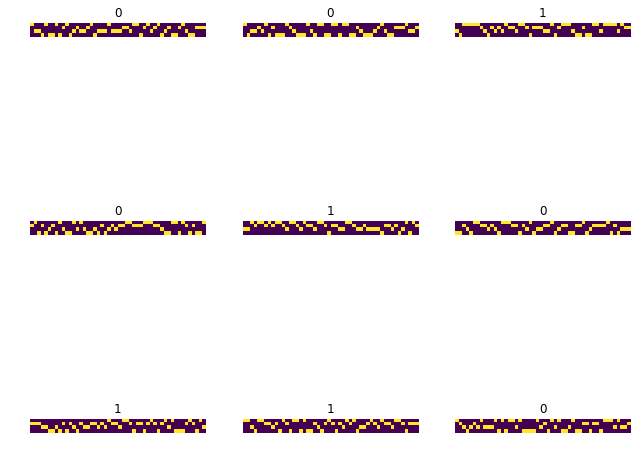

In [443]:
data.show_batch(rows=3)

# Model setup

In [444]:
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))

In [458]:
basic_model = nn.Sequential(nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                            nn.MaxPool1d(kernel_size=4),
                            Flatten(),
                            nn.Linear(in_features=288, out_features=16),
                            nn.ReLU(),
                            nn.Linear(in_features=16, out_features=1)
                           )

In [459]:
basic_model

Sequential(
  (0): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (2): Lambda()
  (3): Linear(in_features=288, out_features=16, bias=True)
  (4): ReLU()
  (5): Linear(in_features=16, out_features=1, bias=True)
)

In [464]:
data.train_ds[0]

(Image (1, 4, 50), Category 0)

In [460]:
data.train_ds[0][0].data.shape

torch.Size([1, 4, 50])

In [461]:
basic_model(data.train_ds[0][0].data)

tensor([[0.0896]], grad_fn=<ThAddmmBackward>)

# Learner setup

In [465]:
learn = create_cnn(data, basic_model, pretrained=False)

TypeError: conv1d(): argument 'input' (position 1) must be Tensor, not bool